In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py

ag_ha = attrgetter(*'t v_0 v_c v_1 a_max'.split())
ag = attrgetter(*'x t v_0 v_c v_1 v_max a_max'.split())

def ch(v):
    for e in chain(*v):
        if e is not None:
            yield e

j = Joint(5_000, 50_000)
       
   

In [45]:
from trajectory.gsolver import * 
accel_xt(0, 500, j.a_max), accel_xt(0, 1000, j.a_max),  accel_xt(0, 2000, j.a_max), 

((2.5, 0.01), (10.0, 0.02), (40.0, 0.04))

In [24]:
j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)  
x = 1000

sl.move([x,x/4])

b = sl[0][0]
print(b.t)
ss = b.iter_steps()

l= list(ss)
len(l)


0.30006518899294243


75017

<AxesSubplot:xlabel='t'>

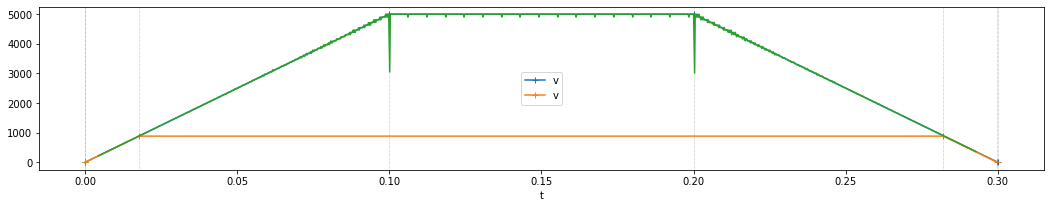

In [29]:
j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)  
x = 1000

sl.move([x,x/4])

ax = sl.plot()

b = sl[0][0]
t = pd.Series(list(s[1] for s in b.iter_steps()))
#ax = (t.rolling(500).mean()*(250_000)).plot(figsize=(20,3))

# Calculate velocity
x = t.to_frame('step')
x['t'] = 4/1e6
x['t'] = x.t.cumsum()
x = x[x.step==1]
v = (1/x.t.diff()).to_frame('v')
x = x.join(v)
x = x[x.v < 20_000]
x.set_index('t').v.plot(ax=ax)



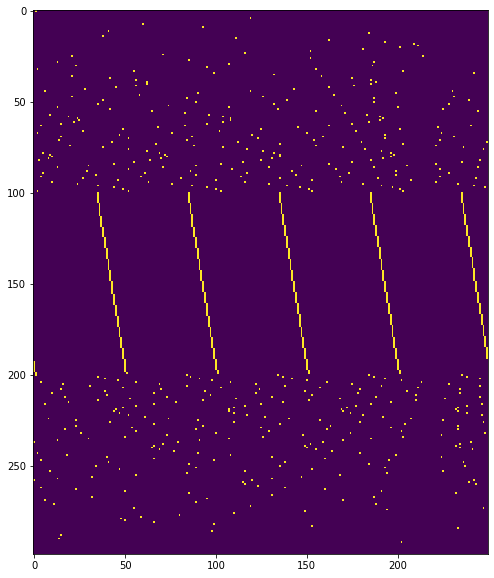

In [50]:
l = 299
last = l*(len(t)//l)
img = t.values[:last].reshape( (l,-1) )

from matplotlib import pyplot as plt
fig,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(img, interpolation='nearest')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


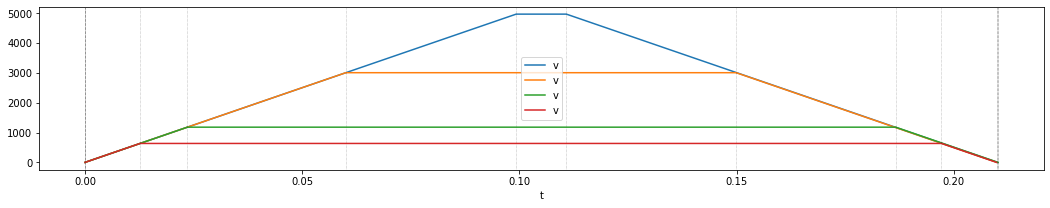

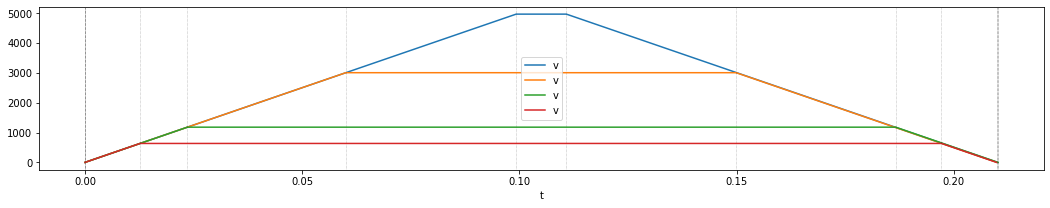

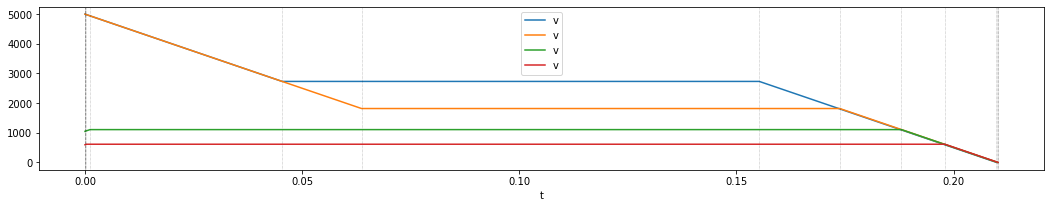

In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from trajectory.planner import Joint, SegmentList
from trajectory.plot import *
from trajectory.planner import Segment, SegmentList, Joint

j = Joint(5_000, 50_000)
joints = [j]*4
s = Segment(0, [550, 450, 220, 125], joints)
sl[0].plan(v_0=0, v_1=0)
s.plan()
s.plot()
sl[0].plan(v_0=j.v_max, v_1=j.v_max)
s.plot()
s.plan(v_0=j.v_max, v_1=0)
s.plot()


[3, 3, 3, 3]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0


Counter({'N': 28, 'VC': 11, 'T1': 1})

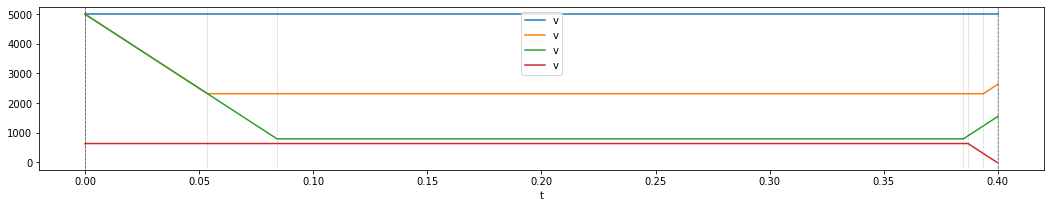

In [98]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from trajectory.planner import Joint, SegmentList
from trajectory.plot import *
from trajectory.planner import Segment, SegmentList, Joint

joints = [Joint(5_000, 50_000),Joint(5_000, 50_000),Joint(5_000, 50_000),Joint(5_000, 50_000)]
for i,j in enumerate(joints):
    j.n = int(i)
 
s = Segment(0, [2000,1000,500,250], joints)

s.plan(v_0=j.v_max, v_1=j.v_max)
s.plot()

print(s.dominant)
Counter(chain(*[b.reductions for b in s]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0.0010097484835343792, 0.014863384540541218, 3.181980515340684e-05, 0.03858540283578753, 0.0, 5.2325901807817595e-05]


0.2520|[0        245↗   711@4951  ↘44      4482] [0        243↗   753@4935  ↘3       4969]
0.2021|[4482       2↗   895@4453  ↘2       4482] [4969       2↗   908@4996  ↘89      4007]
0.2044|[4482      48↗   831@4998  ↘120     3603] [4007       7↗   785@3913  ↘7       4007]
0.2021|[3603      10↗   676@3460  ↘13      3652] [4007      89↗   902@4996  ↘8       4911]
0.2036|[3652     116↗   884@4997  ↘0       4997] [4911       0↗  1000@4910  ↘0       4911]
0.2501|[4997       0↗   750@4998  ↘249        0] [4911       8↗   742@4998  ↘249        0]

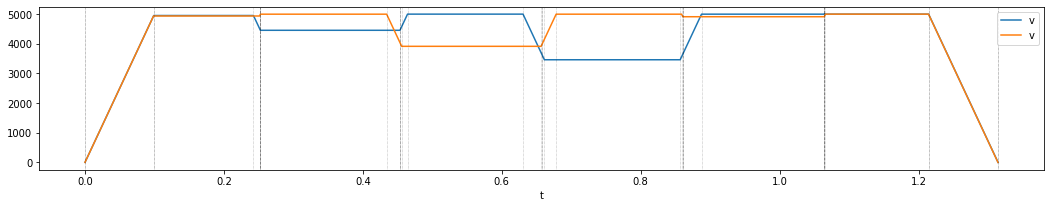

In [99]:
# Too many planning updates for sid=1.
%load_ext autoreload
%autoreload 2
%matplotlib inline
from trajectory.planner import Segment, SegmentList, Joint
from trajectory.gsolver import ACDBlock

j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)   
s = sl.move([1000,1000])
s = sl.move([900,1000])
s = sl.move([1000,800])
s = sl.move([700,1000])
s = sl.move([1000,1000])
s = sl.move([1000,1000])
sl.plot()
print([s.times_e_rms for  s in sl])
sl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]
[(4, 4), (2, 2)]


<Figure size 432x288 with 0 Axes>

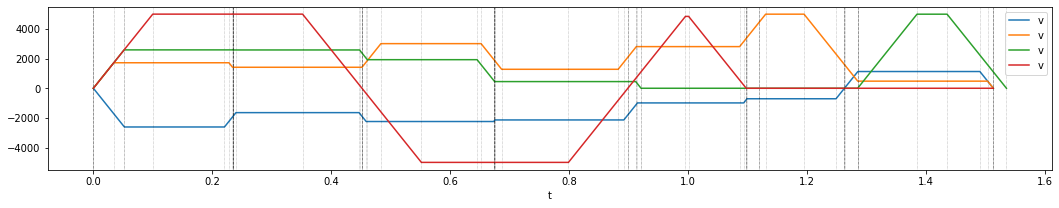

In [100]:
# Too many planning updates for sid=1.
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run startup.py

from trajectory.planner import Segment, SegmentList, Joint

j = Joint(5_000, 50_000)
joints = [j]*4

sl = SegmentList(joints)  

sl.move([-538, 372, 539, 920])
sl.move([-359, 308, 562, 838])
sl.move([-497, 631, 409, -861])
sl.move([-479, 298, 109, -874])
sl.move([-203, 557, 0, 495])
sl.move([-112, 683, 0, 0])
sl.move([257, 130, 751, 0])


sl.plot()

print([ (c.id, round(c.v_1), round(n.v_0)) for c, n in sl.discontinuities()])

print(Counter(sl.replans).most_common(10))

[]
[0.0632919942962773, 0.08828426942978007, 0.07147187736445713, 0.11093605866443967, 0.07937576887606612, 0.05912402640213199, 0.12187367181908759]
[(4, 4), (2, 2)]
2849


<Figure size 432x288 with 0 Axes>

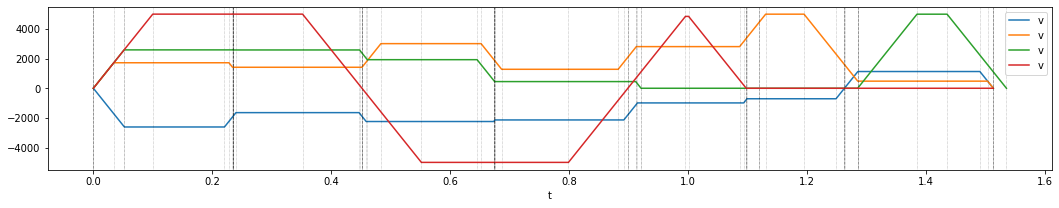

In [101]:
%run startup.py

from trajectory.planner import Segment, SegmentList, Joint

j = Joint(5_000, 50_000)
joints = [j]*4

sl = SegmentList(joints)  

sl.move([-538, 372, 539, 920])
sl.move([-359, 308, 562, 838])
sl.move([-497, 631, 409, -861])
sl.move([-479, 298, 109, -874])
sl.move([-203, 557, 0, 495])
sl.move([-112, 683, 0, 0])
sl.move([257, 130, 751, 0])

sl.plot()
print([ (c.id, round(c.v_1), round(n.v_0)) for c, n in sl.discontinuities()])
print([s.times_e_rms for s in sl])
print(Counter(sl.replans).most_common(10))
print(sum([b.replans for b in  sl.blocks]))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

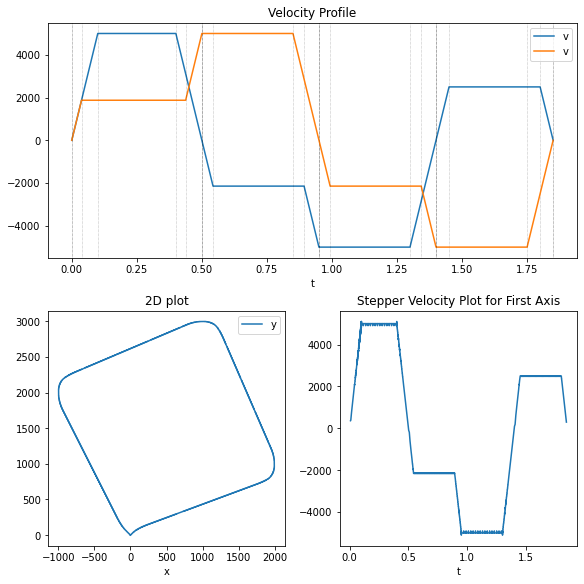

In [22]:

%load_ext autoreload
%autoreload 2
%matplotlib inline
%run startup.py
import matplotlib.pylab as plt
from trajectory.planner import Segment, SegmentList, Joint

j = Joint(5_000, 50_000)
joints = [j]*2

x=2000
sl = SegmentList(joints)   
sl.move([x,x/2])
sl.move([-x/2,x])
sl.move([-x,-x/2])
sl.move([x/2,-x])

stepper_plot(sl)

In [20]:
df = seg_step(sl, details=True)
idx = df.reset_index().groupby(['sg','ph']).t.max()
idx

sg  ph
0   1     0.099920
    2     0.399976
    3     0.508024
1   1     0.550700
    2     0.900516
    3     0.957568
2   1     0.957572
    2     1.307632
    3     1.415680
3   1     1.465096
    2     1.815236
    3     1.870680
Name: t, dtype: float64

In [21]:
lt = idx.loc[(0,3)]
df.loc[lt-.00005:lt+.00005]

,s,dr,pt,tf,v,a,sl,pl,sg,ph,dl,dc,xc,xe
t,,,,,,,,,,,,,,
0.507976,0,1,0.108000,0.10002,-398.640296,-49980.002000,1,-1995,0,3,0.002509,0.002451,2.484086e+02,5.913717e-01
0.507980,0,1,0.108004,0.10002,-398.840216,-49980.002000,1,-1996,0,3,0.002507,0.002455,2.484070e+02,5.929674e-01
0.507984,0,1,0.108008,0.10002,-399.040136,-49980.002000,1,-1997,0,3,0.002506,0.002459,2.484054e+02,5.945640e-01
0.507988,0,1,0.108012,0.10002,-399.240056,-49980.002000,1,-1998,0,3,0.002505,0.002463,2.484038e+02,5.961613e-01
0.507992,0,1,0.108016,0.10002,-399.439976,-49980.002000,1,-1999,0,3,0.002504,0.002467,2.484022e+02,5.977595e-01
0.507996,0,1,0.108020,0.10002,-399.639896,-49980.002000,1,-2000,0,3,0.002502,0.002471,2.484006e+02,5.993585e-01
0.508000,0,1,0.108024,0.10002,-399.839816,-49980.002000,1,-2001,0,3,0.002501,0.002475,2.483990e+02,6.009582e-01
0.508004,0,1,0.108028,0.10002,-400.039736,-49980.002000,1,-2002,0,3,0.002500,0.002479,2.483974e+02,6.025588e-01
0.508008,0,1,0.108032,0.10002,-400.239656,-49980.002000,1,-2003,0,3,0.002499,0.002483,2.483958e+02,6.041601e-01


,v
t,
0.949136,-5000.000000
0.949336,-5000.000000
0.949536,-5000.000000
0.950288,-1329.787234
0.950488,-5000.000000
0.950688,-5000.000000
0.950888,-5000.000000


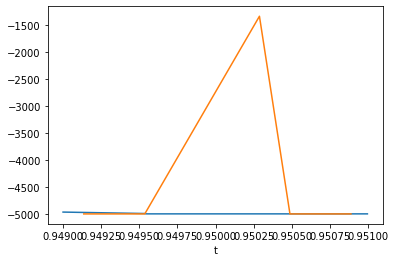

In [179]:
ax = df.loc[0.949:0.951].v.plot()
v = step_v_df(sl)
v.loc[0.949:0.951].v.plot(ax=ax)
v.loc[0.949:0.951]

,s,dr,pt,tf,v,a,sl,pl,sg,ph,dl,dc,xc,xe
t,,,,,,,,,,,,,,
0.949520,0,-1,0.057036,0.057135,-4991.863985,-49934.492647,1,25,1,3,0.0002,0.000188,203.506265,-0.506265
0.949524,0,-1,0.057040,0.057135,-4992.063723,-49934.492647,1,24,1,3,0.0002,0.000192,203.526234,-0.526234
0.949528,0,-1,0.057044,0.057135,-4992.263461,-49934.492647,1,23,1,3,0.0002,0.000196,203.546203,-0.546203
0.949532,0,-1,0.057048,0.057135,-4992.463199,-49934.492647,1,22,1,3,0.0002,0.000200,203.566174,-0.566174
0.949536,-1,-1,0.057052,0.057135,-4992.662937,-49934.492647,0,21,1,3,0.0002,0.000004,203.586145,0.413855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.949544,0,-1,0.000004,0.350070,-4999.000000,0.000000,1750,87517,2,2,0.0002,0.000016,0.019996,-0.019996
0.949548,0,-1,0.000008,0.350070,-4999.000000,0.000000,1750,87516,2,2,0.0002,0.000020,0.039992,-0.039992
0.949552,0,-1,0.000012,0.350070,-4999.000000,0.000000,1750,87515,2,2,0.0002,0.000024,0.059988,-0.059988


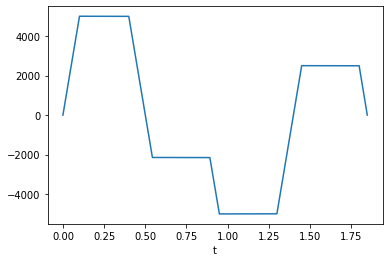

In [169]:
df = seg_step(sl, details=True)

df.v.plot()

seg1_t0=df[(df.sg == 2) & (df.ph == 1)].head().index[0]
t = df.loc[seg1_t0-.00002:seg1_t0+.00002]
t

In [170]:
t = df.loc[0.949:0.951].reset_index()
t =t[t.s!=0]
t['vc'] = t.t.diff()
t

,t,s,dr,pt,tf,v,a,sl,pl,sg,ph,dl,dc,xc,xe,vc
34,0.949136,-1,-1,0.056652,0.057135,-4972.689139,-49934.492647,2,121,1,3,0.000201,0.000005,201.592994,0.407006,NaN
84,0.949336,-1,-1,0.056852,0.057135,-4982.676038,-49934.492647,1,71,1,3,0.000201,0.000004,202.588571,0.411429,0.0002
134,0.949536,-1,-1,0.057052,0.057135,-4992.662937,-49934.492647,0,21,1,3,0.000200,0.000004,203.586145,0.413855,0.0002
322,0.949736,-1,-1,0.000196,0.350070,-4999.000000,0.000000,1749,87469,2,2,0.000200,0.000008,0.979804,0.020196,0.0002
372,0.949936,-1,-1,0.000396,0.350070,-4999.000000,0.000000,1748,87419,2,2,0.000200,0.000008,1.979604,0.020396,0.0002
422,0.950136,-1,-1,0.000596,0.350070,-4999.000000,0.000000,1747,87369,2,2,0.000200,0.000008,2.979404,0.020596,0.0002
472,0.950336,-1,-1,0.000796,0.350070,-4999.000000,0.000000,1746,87319,2,2,0.000200,0.000008,3.979204,0.020796,0.0002
522,0.950536,-1,-1,0.000996,0.350070,-4999.000000,0.000000,1745,87269,2,2,0.000200,0.000008,4.979004,0.020996,0.0002
572,0.950736,-1,-1,0.001196,0.350070,-4999.000000,0.000000,1744,87219,2,2,0.000200,0.000008,5.978804,0.021196,0.0002
622,0.950936,-1,-1,0.001396,0.350070,-4999.000000,0.000000,1743,87169,2,2,0.000200,0.000008,6.978604,0.021396,0.0002


In [185]:
l = list(sl.step(details=True))
df = pd.DataFrame(l)
df.head()

,s,dr,t,pt,tf,v,a,sl,pl,sg,ph,dl,dc,xc,xe
0,0,1,0.000004,0.000004,0.10002,0.00000,49980.002,250,25004,0,0,0.000000,0.000008,3.998400e-07,-3.998400e-07
1,1,1,0.000008,0.000008,0.10002,0.19992,49980.002,249,25003,0,0,5.002001,0.000012,1.599360e-06,9.999984e-01
2,0,1,0.000012,0.000012,0.10002,0.39984,49980.002,249,25002,0,0,2.501000,0.000016,3.598560e-06,9.999964e-01
3,0,1,0.000016,0.000016,0.10002,0.59976,49980.002,249,25001,0,0,1.667334,0.000020,6.397440e-06,9.999936e-01
4,0,1,0.000020,0.000020,0.10002,0.79968,49980.002,249,25000,0,0,1.250500,0.000024,9.996000e-06,9.999900e-01


In [187]:
l = list(sl.step())
l[:10]

[[0, 0, 0],
 [4e-06, 1, 0],
 [8e-06, 0, 0],
 [1.2e-05, 0, 0],
 [1.6e-05, 0, 0],
 [1.9999999999999998e-05, 0, 0],
 [2.3999999999999997e-05, 0, 0],
 [2.7999999999999996e-05, 0, 0],
 [3.2e-05, 0, 0],
 [3.6e-05, 0, 0]]